# Kriging the short dataset

In [111]:
from importlib import reload
try:
    reload(kriging_modified)
    from kriging import Kriging
except:
    import kriging
    reload(kriging)
    from kriging import Kriging
import numpy as np
import matplotlib.pyplot as plt

import time

In [112]:
freqarr, freqstep = np.linspace(0,250,4096,retstep=True) # Based on number of frequency channels of the antenna
minfreq = 100
# maxfreq = 
minfreqarg = int(minfreq/freqstep)
maxfreqarg = minfreqarg
# print(freqstep)
# print(freqarr[minfreqarg:maxfreqarg])
# freq = 100 # MHz
# freq_index = int(freq/freqstep)
freq=minfreq
freq_index = minfreqarg
print(freq_index)

1638


In [113]:
# Load in the data
year = '2021'
instrument = '100MHz'
channel = 'NS'

datadir = '../test_data/'+year+'/'+instrument+'/'+channel+'/'

save_mask = np.load(datadir+'shortdata_'+year+'_'+instrument+'_'+channel+'_mask.npy')
dat=np.load(datadir+'shortdata_meas_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
lst=np.load(datadir+'shortlst_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
t=np.load(datadir+'shortsystime_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
t_ant = np.load(datadir+'antsystime_'+year+'_'+instrument+'_'+channel+'.npy')

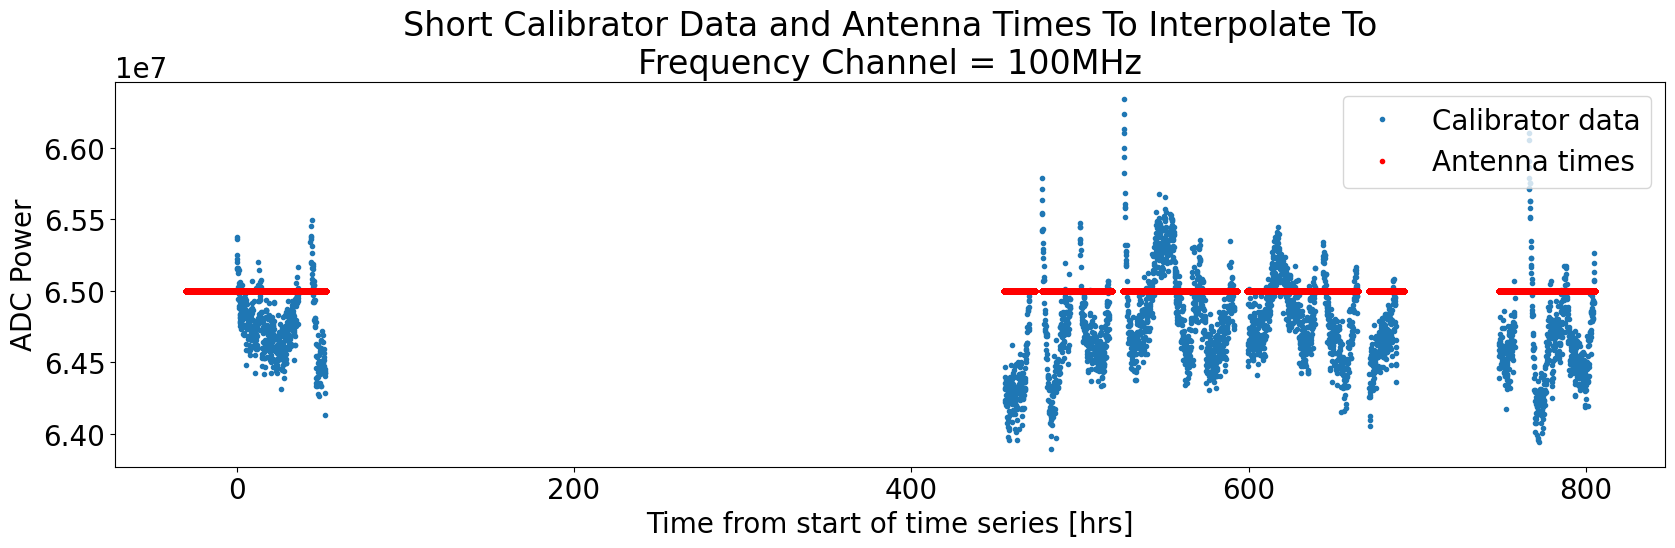

In [114]:
# Optional: select a subset of the data (mostly for testing)
# tmax=1.6374e9
# tmin=1.6365e9
# tmax=1.636e9
tmax=np.inf
tmin=0

mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]

ant_mask = (t_ant>tmin)&(t_ant<tmax)
tt_ant = t_ant[ant_mask]

# Pick a freq_index to plot (the fit is done for all frequencies)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,5))
plt.plot((tt-tt[0])/3600,dd[:,freq_index],'.',label='Calibrator data')
plt.plot((tt_ant-tt[0])/3600,[6.5e7 for ti in tt_ant],'.',color='red',label='Antenna times')
plt.title('Short Calibrator Data and Antenna Times To Interpolate To\nFrequency Channel = '+str(freq)+'MHz')
# plt.xlim(left=-40,right=60)
# plt.xlim(left=450)
plt.xlabel('Time from start of time series [hrs]')
plt.ylabel('ADC Power')
plt.legend(loc='upper right')
# plt.savefig('PreInterp3.png',bbox_inches='tight',dpi=300)
plt.show()

In [123]:
# Step 1: Initialize Kriging class
# You can actually pass tmax and tmin to the Kriging object and it'll select for you
krig_object = Kriging(systime=t,data=dat,interp_times=t_ant,tmax_mask=tmax,tmin_mask=tmin,
                      minfreqarg=minfreqarg,maxfreqarg=maxfreqarg)

Verifying freq args are the same within kriging object: min 1638 , max 1638


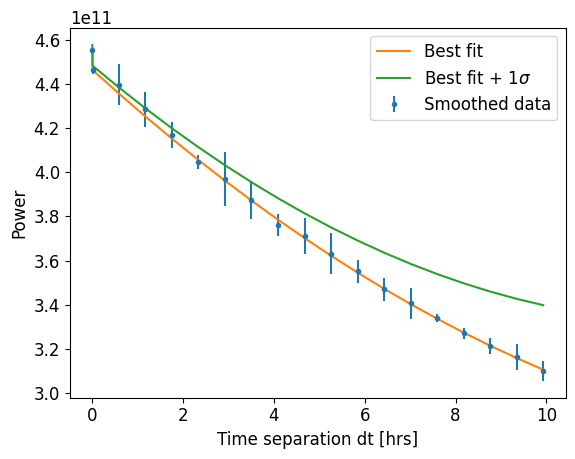

100.0 MHz channel done
Time taken: 458.7142984867096 sec


In [124]:
# Step 2: Call the object to perform the Kriging
tstart = time.time()
krig_object(dt=5,dtmax=10*3600,acf_functype='quadpeak') # dt and dtmax in seconds
tend = time.time()
print('Time taken:',tend-tstart,'sec')

In [125]:
slct = 0
rslt = krig_object.interp_data[slct]
rslt_1s = krig_object.interp1s_data[slct]
err = krig_object.interp_std[slct]
err_1s = krig_object.interp1s_std[slct]
avgd_time = krig_object.save_avgd_time[slct]
avgd_data = krig_object.save_avgd_data[slct]
avgd_data_std = krig_object.save_avgd_data_std[slct]

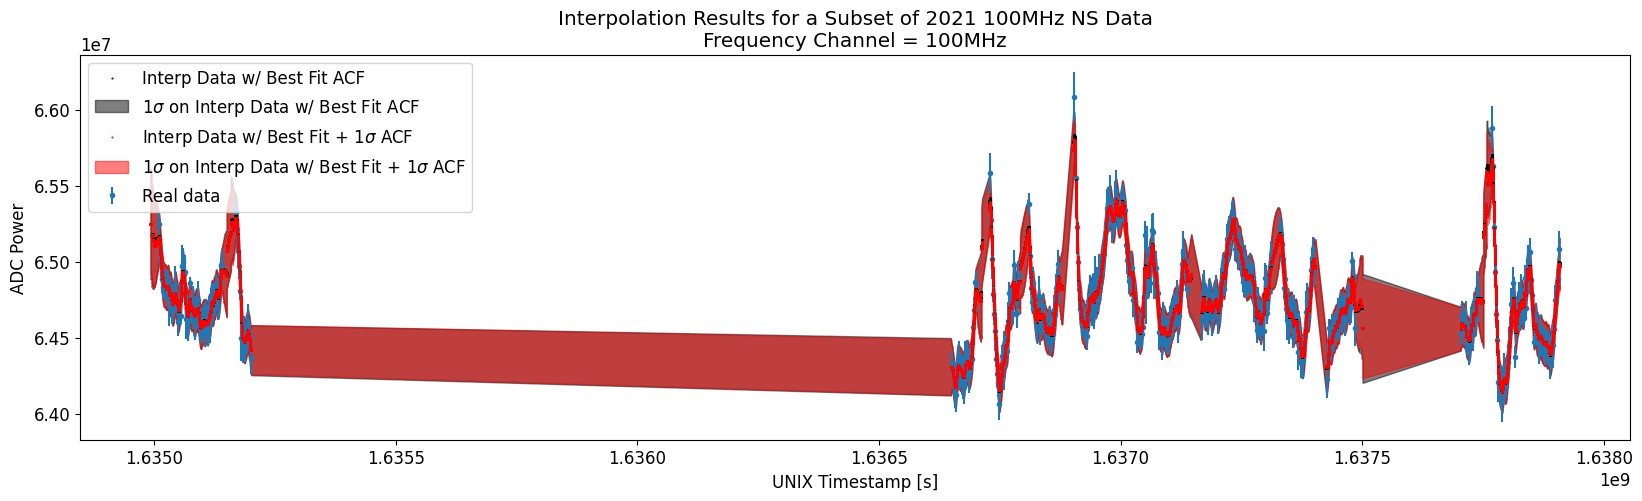

In [115]:
fig = plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 12})


plt.errorbar(x=avgd_time,y=avgd_data,yerr=avgd_data_std,marker='.',label='Real data',ls='none',zorder=1)

plt.plot(tt_ant,rslt,'.',ms=1,label='Interp Data w/ Best Fit ACF',color='k',zorder=2)
plt.fill_between(tt_ant,(rslt-err),(rslt+err),alpha=0.5,color='k',zorder=0,label=r'1$\sigma$ on Interp Data w/ Best Fit ACF')
plt.plot(tt_ant,rslt_1s,'.',ms=1,label='Interp Data w/ Best Fit + $1\sigma$ ACF',color='r',zorder=2)
plt.fill_between(tt_ant,(rslt_1s-err_1s),(rslt_1s+err_1s),alpha=0.5,color='r',zorder=0,label=r'1$\sigma$ on Interp Data w/ Best Fit + $1\sigma$ ACF')

# plt.ylim(bottom=7e7)
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('ADC Power')
plt.legend()
plt.title('Interpolation Results for a Subset of '+year+' '+instrument+' '+channel+' Data\nFrequency Channel = '+str(freq)+'MHz')
# plt.plot(tt_ant,[6.6e7 for ti in tt_ant],'.',color='red',label='Antenna times (interp times)')
# plt.xlim(left= 1.6365e9,right=1.6380e9)
# plt.ylim(top=6.9e7,bottom=6.4e7)
# plt.savefig('InterpRslt',dpi=300)
plt.show()

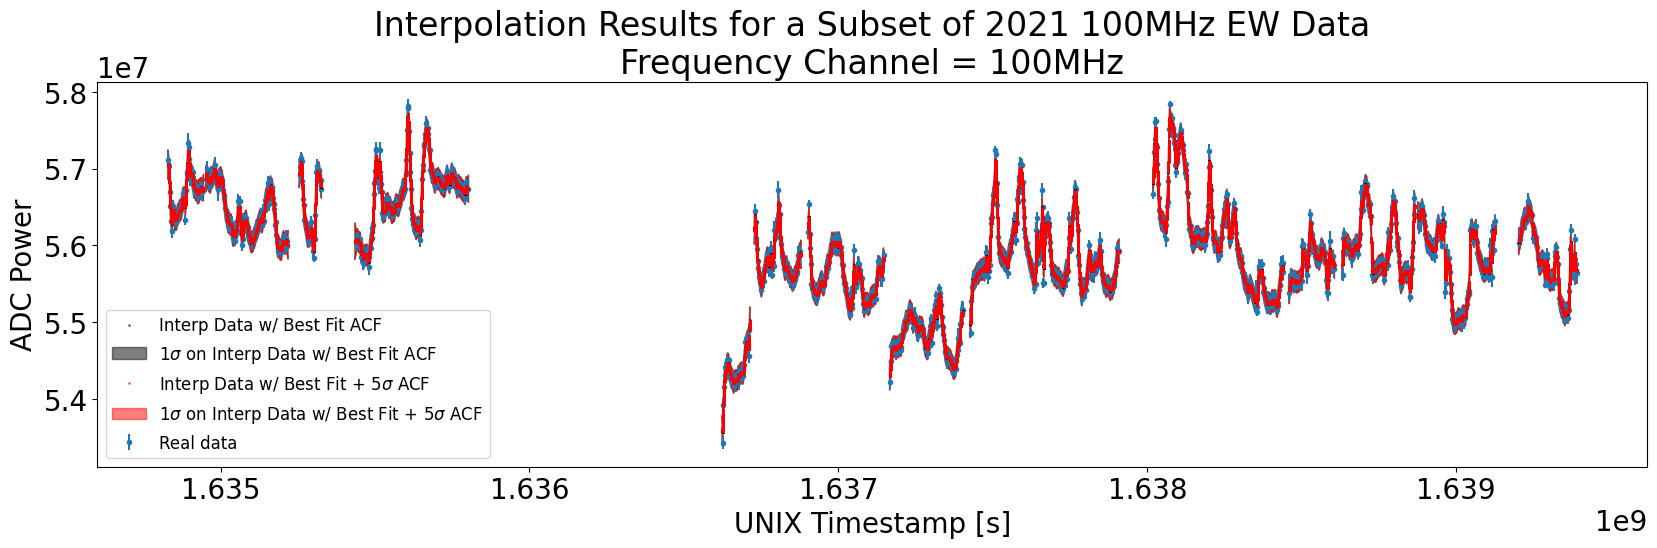

In [126]:
fig = plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 20})

# Select frequency ------
freq = 100 # MHz
freq_index = int(freq/freqstep)
# -----------------------

# Plot the averaged data with error bars
x = tt_ant
y1 = (rslt-err)
y2 = (rslt+err)
y3 = (rslt_1s-err_1s)
y4 = (rslt_1s+err_1s)

gap_threshold = 60*60 # 1h gap threshold
mask = np.ediff1d(x, to_begin=0) > gap_threshold

x_masked = np.ma.masked_where(mask, x)
y1_masked = np.ma.masked_where(mask, y1)
y2_masked = np.ma.masked_where(mask, y2)
y3_masked = np.ma.masked_where(mask, y3)
y4_masked = np.ma.masked_where(mask, y4)

plt.errorbar(x=avgd_time,y=avgd_data,yerr=avgd_data_std,marker='.',label='Real data',ls='none',zorder=1)

# Plot the results of the interpolation at antenna times
plt.plot(tt_ant,rslt,'.',ms=1,label='Interp Data w/ Best Fit ACF',color='k',zorder=2)
plt.fill_between(x_masked,y1_masked,y2_masked,alpha=0.5,color='k',zorder=0,label=r'1$\sigma$ on Interp Data w/ Best Fit ACF')
plt.plot(tt_ant,rslt_1s,'.',ms=1,label='Interp Data w/ Best Fit + $5\sigma$ ACF',color='r',zorder=2)
plt.fill_between(x_masked,y3_masked,y4_masked,alpha=0.5,color='r',zorder=0,label=r'1$\sigma$ on Interp Data w/ Best Fit + $5\sigma$ ACF')

# plt.ylim(bottom=7e7)
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('ADC Power')
plt.title('Interpolation Results for a Subset of '+year+' '+instrument+' '+channel+' Data\nFrequency Channel = '+str(freq)+'MHz')
plt.rcParams.update({'font.size': 12})
plt.legend()
plt.show()

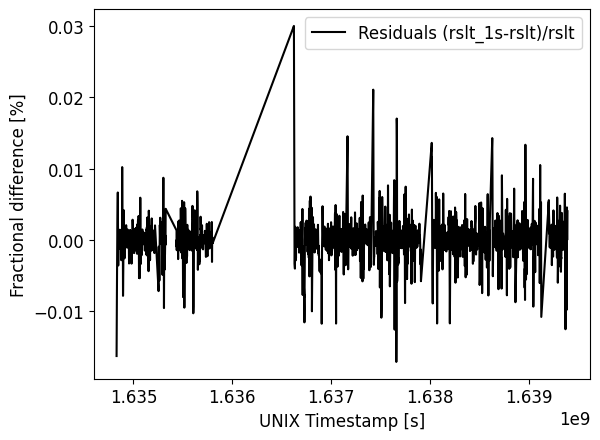

In [127]:
# Residual plot
plt.plot(tt_ant,(rslt_1s-rslt)/rslt *100,ms=1,label='Residuals (rslt_1s-rslt)/rslt',color='k',zorder=2)
# plt.ylim(top=0.002,bottom=-0.002)
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('Fractional difference [%]')
plt.rcParams.update({'font.size': 12})
plt.legend()
plt.show()
# ((rslt_1s-rslt)/rslt)[99000:100000]

## ACF for separate portions

This has two purposes:

1. Checking if the ACF is consistent throughout the dataset. This is meant to justify if a 5-10h threshold for interpolation is sensible. If we can show that datapoints far from each other (i.e. 5 or 10h away) aren't very dependent on each other, then the threshold is fine. Jon suggests computing the ACF and ACF function for 3 different sub-chunks of the raw data and checking if they are the "same".  If they do, it shows that the data isn't really sensitive to far away points so it justifies putting a threshold a little better.

2. Estimating the error on the Kriging when there is scatter in the data (= error on the covariance matrix). Mohan suggests computing the ACF separately for 3 sub-chunks and looking at how much the error on the prediction from those 3 chunks changes. Can give an idea of the typical value of the true error on the prediction due to scatter in the data.

In [ ]:
# Importing system temperature to check correlations between temperature variations and calibrator power variations


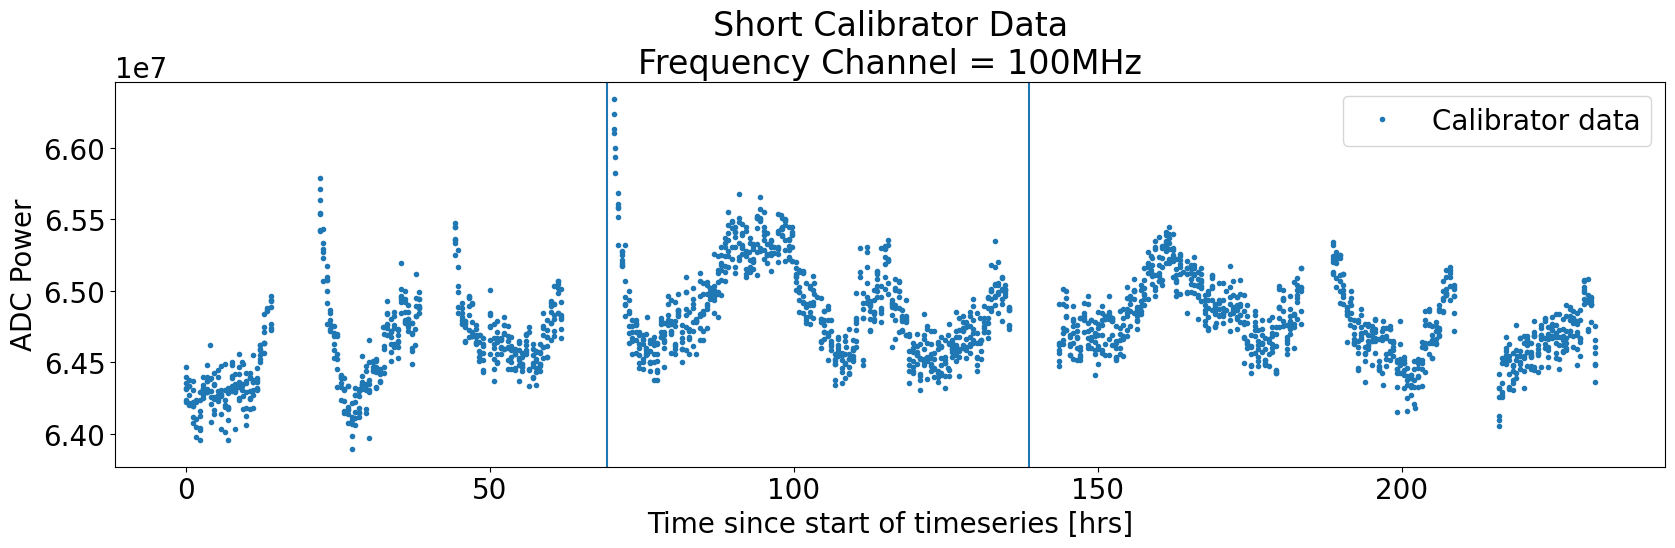

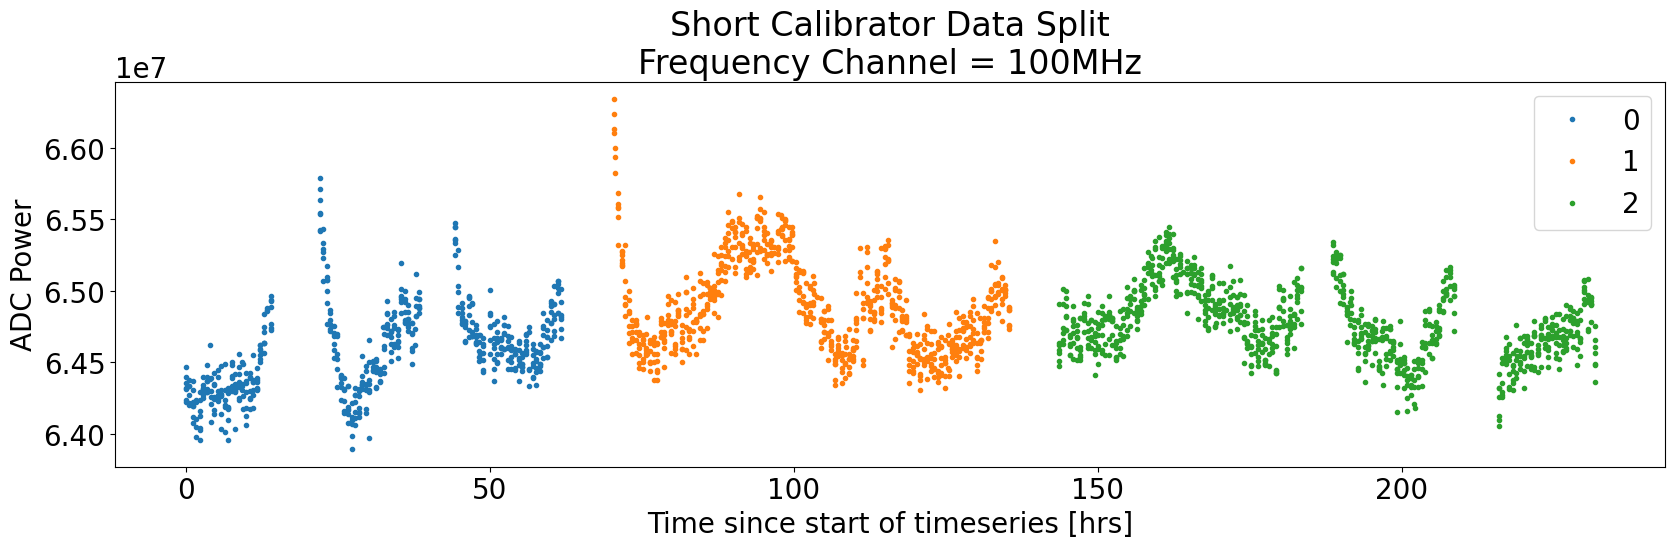

In [174]:
# After loading in pre-interpolation data, I need to divide it into chunks
# Optional: select a subset of the data (mostly for testing)
# tmax=1.6374e9
# tmin=1.6365e9
# tmax=1.636e9
tmax=1.63755e9
tmin=1.6365e9

mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]

ant_mask = (t_ant>tmin)&(t_ant<tmax)
tt_ant = t_ant[ant_mask]

# Pick a freq_index to plot (the fit is done for all frequencies)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,5))
plt.plot((tt-tt[0])/3600,dd[:,freq_index],'.',label='Calibrator data')
# plt.plot(tt_ant,[6.5e7 for ti in tt_ant],'.',color='red',label='Antenna times')
plt.title('Short Calibrator Data\nFrequency Channel = '+str(freq)+'MHz')
# plt.xlim(left=-40,right=60)
# plt.xlim(left=450)
# plt.xlabel('UNIX Timestamp [s]')
plt.xlabel('Time since start of timeseries [hrs]')
plt.ylabel('ADC Power')
plt.legend(loc='upper right')
# plt.savefig('PreInterp3.png',bbox_inches='tight',dpi=300)


# Divide into chunks
# split_times = np.array([1.63672,1.6368,1.6369,1.63715,1.63732,1.63742])*1e9 # all separate chunks
split_times = np.array([1.6369,1.63715])*1e9 # 3 big chunks
for i, xx in enumerate(split_times):
    plt.axvline(x=(xx-tt[0])/3600)

plt.show()








# Divide into chunks
plt.figure(figsize=(20,5))
chunks_tt = []
chunks_dd = []

for i, xx in enumerate(split_times):
    if i == 0:
        chunks_tt.append(tt[(tt>tmin)&(tt<xx)])
        chunks_dd.append(dd[(tt>tmin)&(tt<xx)])
        plt.plot((tt[(tt>tmin)&(tt<xx)]-tt[0])/3600,dd[:,freq_index][(tt>tmin)&(tt<xx)],'.',label=i)
    elif i == len(split_times)-1:
        chunks_tt.append(tt[(tt>split_times[i-1])&(tt<xx)])
        chunks_dd.append(dd[(tt>split_times[i-1])&(tt<xx)])
        plt.plot((tt[(tt>split_times[i-1])&(tt<xx)]-tt[0])/3600,dd[:,freq_index][(tt>split_times[i-1])&(tt<xx)],'.',label=i)
        
        chunks_tt.append(tt[(tt>xx)&(tt<tmax)])
        chunks_dd.append(dd[(tt>xx)&(tt<tmax)])
        plt.plot((tt[(tt>xx)&(tt<tmax)]-tt[0])/3600,dd[:,freq_index][(tt>xx)&(tt<tmax)],'.',label=i+1)
    else:
        chunks_tt.append(tt[(tt>split_times[i-1])&(tt<xx)])
        chunks_dd.append(dd[(tt>split_times[i-1])&(tt<xx)])
        plt.plot((tt[(tt>split_times[i-1])&(tt<xx)]-tt[0])/3600,dd[:,freq_index][(tt>split_times[i-1])&(tt<xx)],'.',label=i)


# plt.plot(tt_ant,[6.5e7 for ti in tt_ant],'.',color='red',label='Antenna times')
plt.title('Short Calibrator Data Split\nFrequency Channel = '+str(freq)+'MHz')
# plt.xlim(left=-40,right=60)
# plt.xlim(left=450)
plt.xlabel('Time since start of timeseries [hrs]')
plt.ylabel('ADC Power')
plt.legend(loc='upper right')
# plt.savefig('PreInterp3.png',bbox_inches='tight',dpi=300)

plt.show()

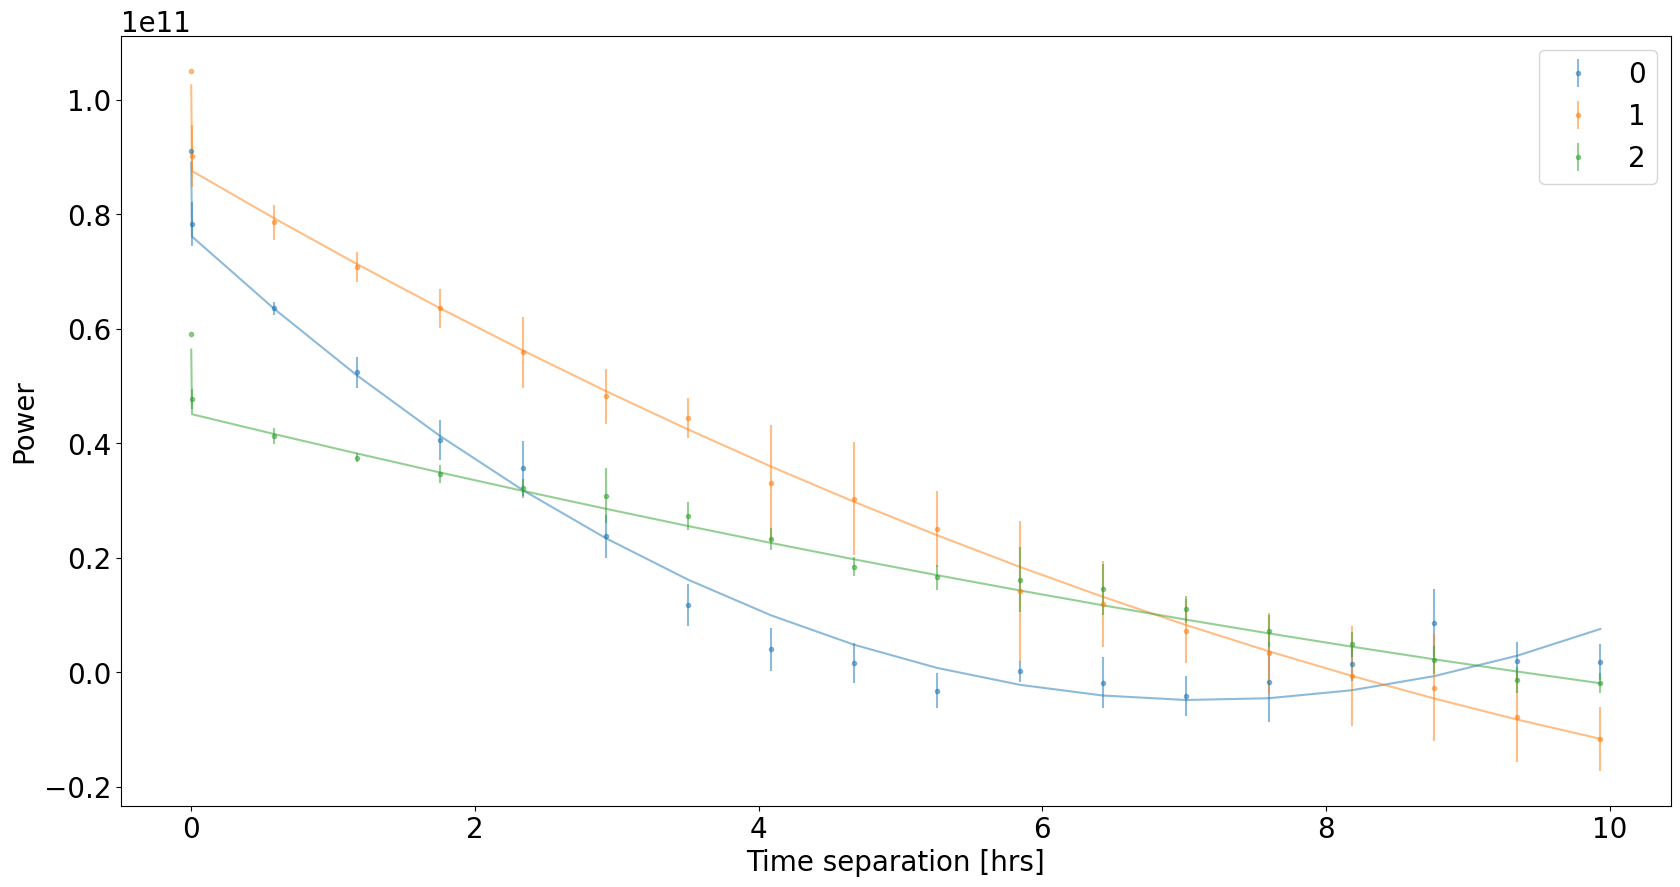

In [132]:
# Use kriging.py to compute the ACF using different chunks. 
# Jon: Compare the ACF for each of those chunks
#Mohan: Use those ACFs to interpolate to one point using the data +-5h around it! Compare

plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] # default matplotlib colors
save_wts = []

plt.figure(figsize=(20,10))
for i in range(len(chunks_tt)):
    
    # initialize Kriging object
    krig_object = Kriging(systime=chunks_tt[i],data=chunks_dd[i],interp_times=t_ant,tmax_mask=tmax,tmin_mask=tmin,
                      minfreqarg=freq_index,maxfreqarg=freq_index+1)
    
    # call the compute_ACF method ONLY
    dt=5
    ktmax=2*86400
    tot,wt = krig_object.make_acf(krig_object.data[:,freq_index]-krig_object.data[:,freq_index].mean(),krig_object.time,dt=dt,tmax=ktmax)
    mm=wt>0.10*len(krig_object.time) # mask ACF entries with less significant weights (<10% of number of datapoints) to get rid of noisy outliers
    save_wts.append(wt)
    #n=int(tmax/dt)
    #mm = wt>1e-15*n**2
    krig_object.acf_tvec = np.arange(len(tot))[mm]*dt
    krig_object.acf = tot[mm]/wt[mm]
    
    # smooth the ACF
    krig_object.acf_tvec, krig_object.acf, krig_object.acf_std = krig_object.smooth_acf(tvec=krig_object.acf_tvec,acf=krig_object.acf,cycle_jump=5*60)
    plt.errorbar(x=(krig_object.acf_tvec/3600)[krig_object.acf_tvec/3600<10],y=(krig_object.acf)[krig_object.acf_tvec/3600<10],yerr=(krig_object.acf_std)[krig_object.acf_tvec/3600<10],
                 marker='.',ls='none',color=plot_colors[i],label=i,alpha=0.5)
    
    # fit the ACF
    dtmax=10*3600
    krig_object.acf_func = krig_object.fit_acf(tvec=krig_object.acf_tvec,acf=krig_object.acf,acf_err=krig_object.acf_std,dtmax=dtmax,functype='quadpeak')
    plt.plot(krig_object.acf_tvec[(krig_object.acf_tvec<dtmax)]/3600,krig_object.acf_func(krig_object.acf_tvec[(krig_object.acf_tvec<dtmax)]/3600),color=plot_colors[i],alpha=0.5)
        
    
    #break # for testing

plt.xlabel('Time separation [hrs]')
plt.ylabel('Power')
plt.legend()
plt.show()

save_wts = np.array(save_wts)

## wt criterion

To determine what the 'wt>...' criterion should be for the bins of the ACF created from the raw data, I will start by plotting just the weights of each bin:

Number of bins with zero weight for ACF0: 32224  out of 34560
Number of bins with zero weight for ACF1: 33125  out of 34560
Number of bins with zero weight for ACF2: 31952  out of 34560


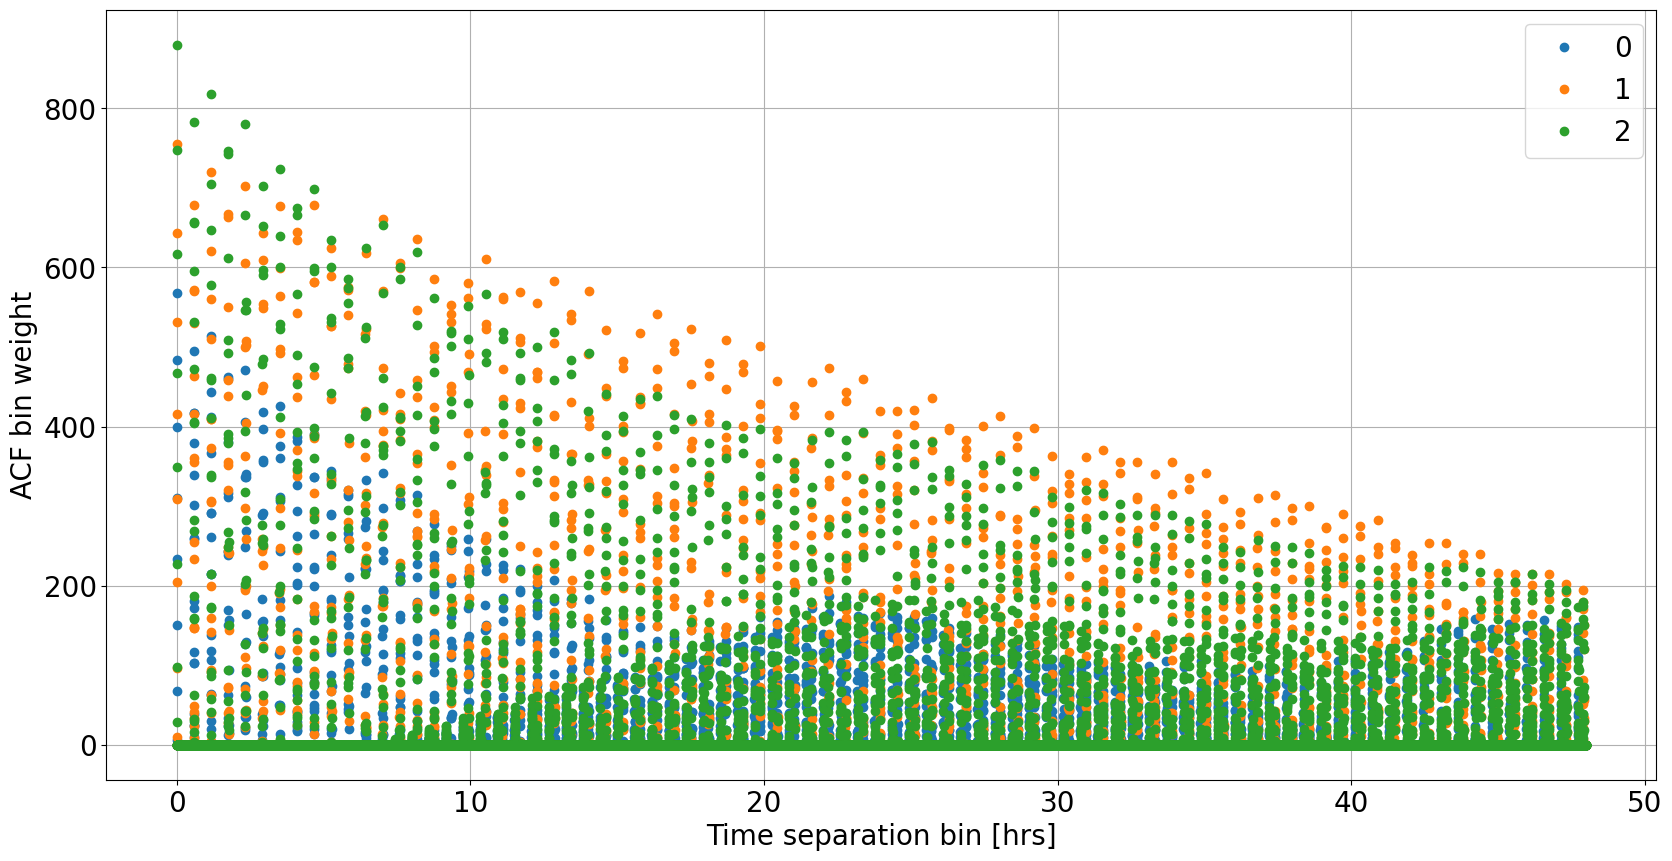

In [162]:
plt.figure(figsize=(20,10))

for i in range(3):
    plt.plot(np.arange(len(tot))*dt/3600,save_wts[i],'o',label=i)
    
    print('Number of bins with zero weight for ACF'+str(i)+': '+str(np.sum(save_wts[i] == 0)),' out of '+str(len(save_wts[i])))

plt.xlabel('Time separation bin [hrs]')
plt.ylabel('ACF bin weight')
# plt.yscale('log')
# plt.ylim(top=10,bottom=-1)
plt.grid('on')
plt.legend()
plt.show()

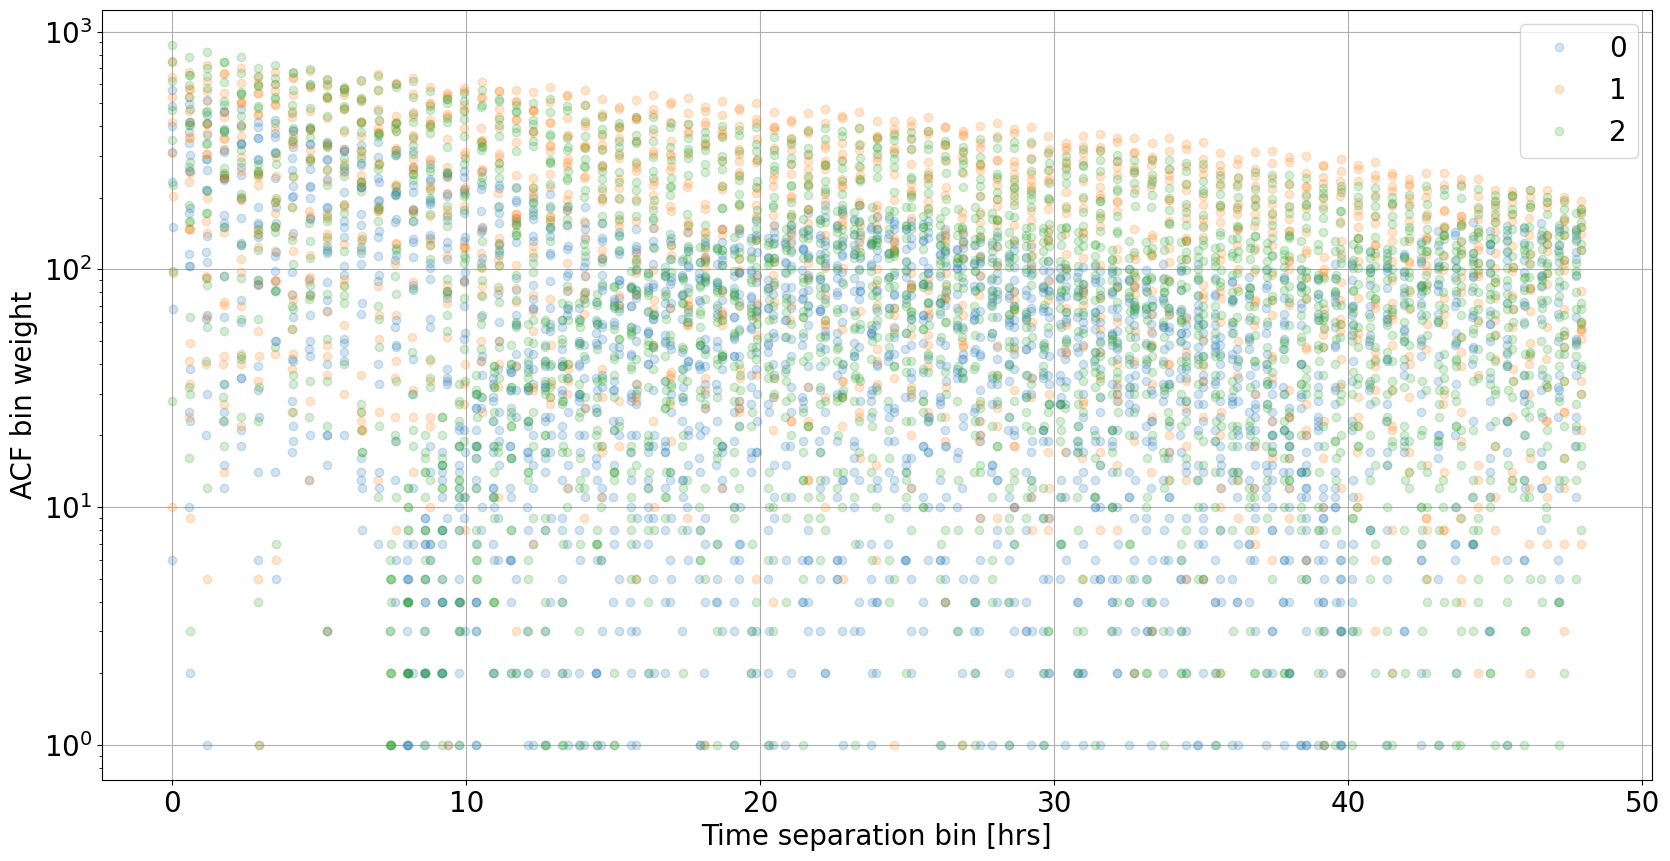

In [166]:
# Plotting only bins weights > 0

plt.figure(figsize=(20,10))

for i in range(3):
    plt.plot((np.arange(len(tot))*dt/3600)[save_wts[i] > 0],save_wts[i][save_wts[i] > 0],'o',label=i,alpha=0.2)
    
plt.xlabel('Time separation bin [hrs]')
plt.ylabel('ACF bin weight')
plt.yscale('log')
# plt.ylim(top=10,bottom=-1)
plt.grid('on')
plt.legend()
plt.show()